In [1]:
import pynsx as nsx
import math
import numpy as np
from matplotlib import pyplot as plt

In [24]:
def compute_statistics(peak_list, group, friedel):
    merged = nsx.MergedData(group, friedel)
    for peak in peaks:
        if peak.isSelected():
            merged.addPeak(nsx.PeakCalc(peak))
            
    r = nsx.RFactor()
    cc = nsx.CC()
    
    r.calculate(merged)
    cc.calculate(merged)
    
    stats = {}
    stats['CChalf'] = cc.CChalf()
    stats['CCtrue'] = cc.CCstar()
    stats['Rmeas'] = r.Rmeas()
    stats['Rmerge'] = r.Rmerge()
    stats['Rpim'] = r.Rpim()
    
    return stats

def predict_peaks(data):
    predictor = nsx.PeakPredictor()
    predictor._dmin = 1.5
    predictor._dmax = 50.0
    predictor._searchRadius = 100.0
    predictor._peakScale = 1.0
    predictor._bkgScale = 3.0
    predictor._handler = nsx.ProgressHandler()
    predictor.addPredictedPeaks(data)
    
def num_selected_peaks(peaks):
    num_selected = 0
    
    for peak in peaks:
        if peak.isSelected():
            num_selected += 1
            
    return num_selected
    
def filter_peaks(peaks):
    for peak in peaks:
        if not peak.isSelected():
            continue
            
        if peak.pValue() > 1e-3:
            peak.setSelected(False)
            continue
        
    
        
def remove_deselected(data):
    peaks = data.getPeaks()
    
    for peak in peaks:
        if not peak.isSelected():
            data.removePeak(peak)

In [3]:
expt = nsx.Experiment('test', 'BioDiff2500')
biodiff = expt.getDiffractometer()
reader = nsx.HDF5DataReader("/home/jonathan/data/biodiff/p11202/p11202.hdf", biodiff)
data = nsx.DataSet(reader, biodiff)
expt.addData(data)

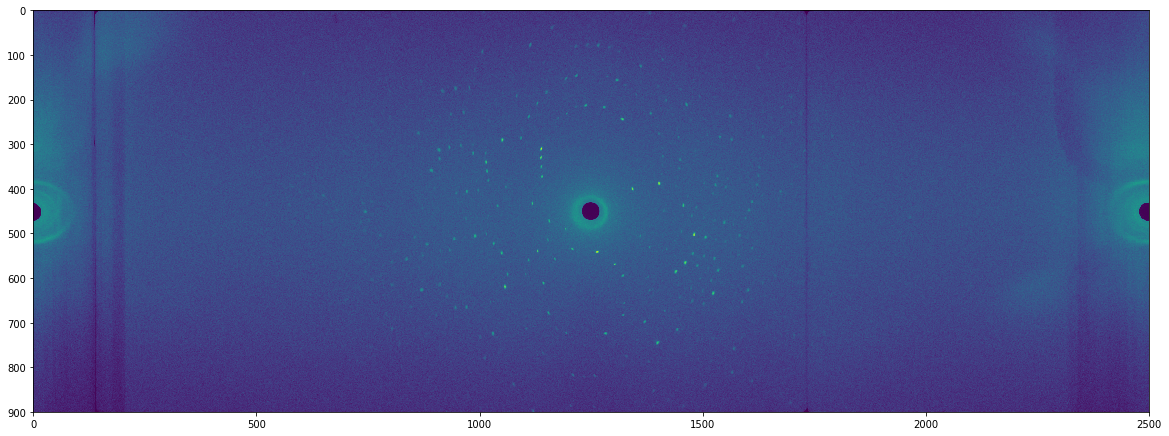

In [4]:
plt.figure(figsize=(20,10))
plt.imshow(np.log(data.getFrame(0)))
plt.show()

In [5]:
kernel = nsx.AnnularKernel(data.getNRows(), data.getNCols())
kernel_image = kernel.getKernel()
convolver = nsx.Convolver()
convolver.setKernel(kernel_image)

In [6]:
finder = nsx.PeakFinder()
finder.setConvolver(convolver)
finder.setMinComponents(30)
finder.setMaxComponents(10000)
finder.setConfidence(0.98)
finder.setThresholdType(1)
finder.setThresholdValue(80.0)
finder.setKernel(kernel)

In [7]:
numors = nsx.vector_data()
numors.push_back(data)
finder.find(numors)
peaks = data.getPeaks()
print(peaks.size())

8925


In [8]:
I = 0.0
I2 = 0.0

for peak in peaks:
    intensity = peak.getCorrectedIntensity().getValue()
    I += intensity
    I2 += intensity**2
    
I /= peaks.size()

variance = (I2 - peaks.size()*I*I) / (peaks.size()-1)
std = math.sqrt(variance)

print("average intensity =", I)
print("std intensity     =", std)

average intensity = 217474.7825892901
std intensity     = 200586.4910000697


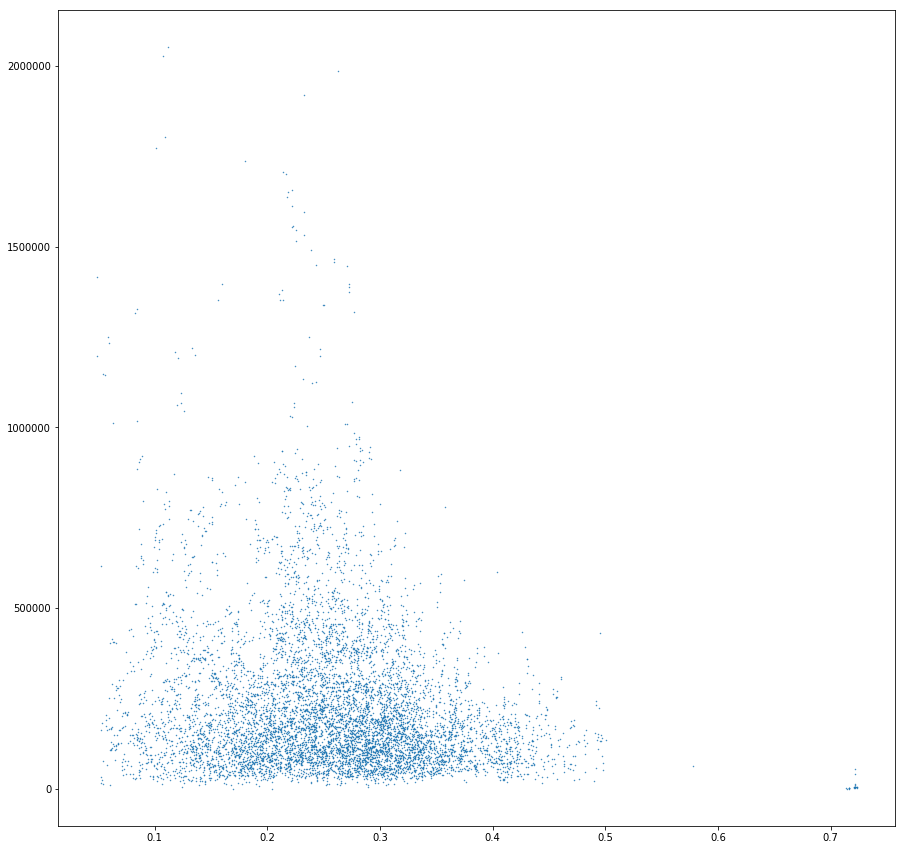

In [9]:
I = []
q = []

for peak in peaks:
    if peak.isSelected() != True:
        continue
    I.append(peak.getCorrectedIntensity().getValue())
    q.append(np.linalg.norm(peak.getQ()))

plt.figure(figsize=(15,15))
plt.scatter(q, I, s=0.2)
plt.show()

In [10]:
indexer = nsx.AutoIndexer(expt, nsx.ProgressHandler())

num_to_index = 0

for peak in peaks:
    d = 1.0 / np.linalg.norm(peak.getQ())
    if peak.isSelected() and d > 2.0 and d < 45.0:
        indexer.addPeak(peak)
        num_to_index += 1

print("indexing", num_to_index, "peaks")
        
params = nsx.IndexerParameters()
handler = nsx.ProgressHandler()
indexer.autoIndex(params)

soln = indexer.getSolutions()[0]
assert(soln[1] > 92.0)

uc = nsx.UnitCell(soln[0])
sample = biodiff.getSample()
sample.addUnitCell(uc)

for peak in peaks:
    peak.addUnitCell(uc, True)

num_peaks = len(peaks)

predictor = nsx.PeakPredictor()
predictor._dmin = 1.5
predictor._dmax = 50.0
predictor._searchRadius = 100.0
predictor._peakScale = 1.0
predictor._bkgScale = 3.0
predictor._handler = nsx.ProgressHandler()

predictor.addPredictedPeaks(data)
predicted_peaks = len(data.getPeaks()) - num_peaks

indexing 8219 peaks


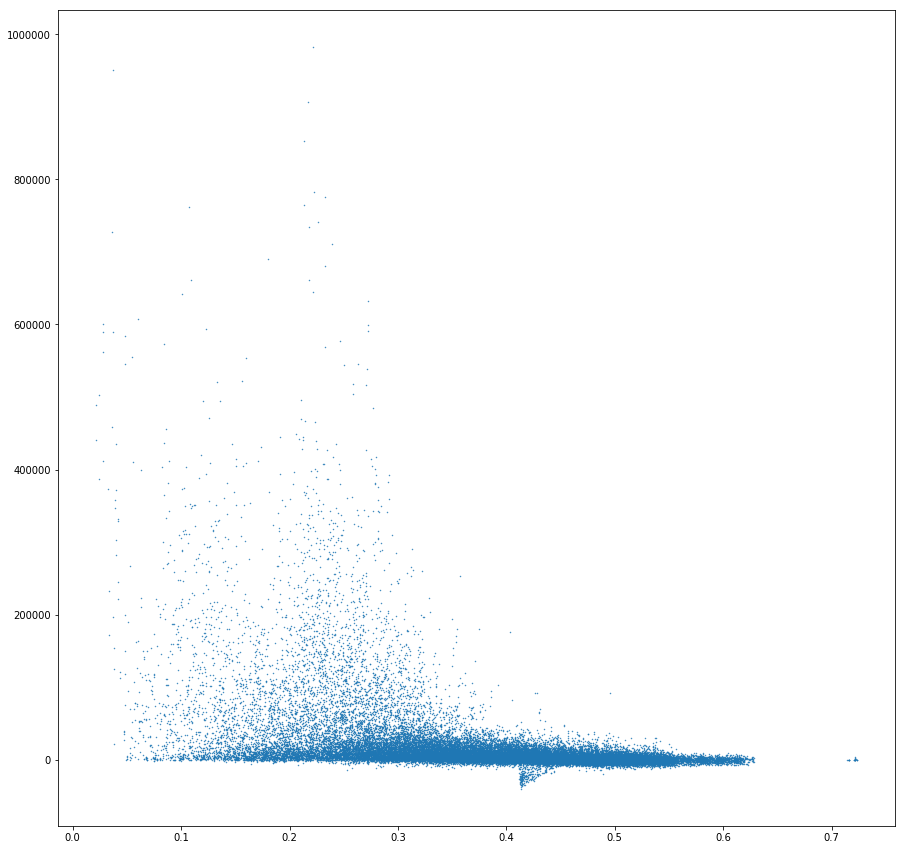

In [11]:
I = []
q = []

for peak in peaks:
    if peak.isSelected() != True:
        continue
    I.append(peak.getCorrectedIntensity().getValue())
    q.append(np.linalg.norm(peak.getQ()))

plt.figure(figsize=(15,15))
plt.scatter(q, I, s=0.2)
plt.show()

23921 peaks


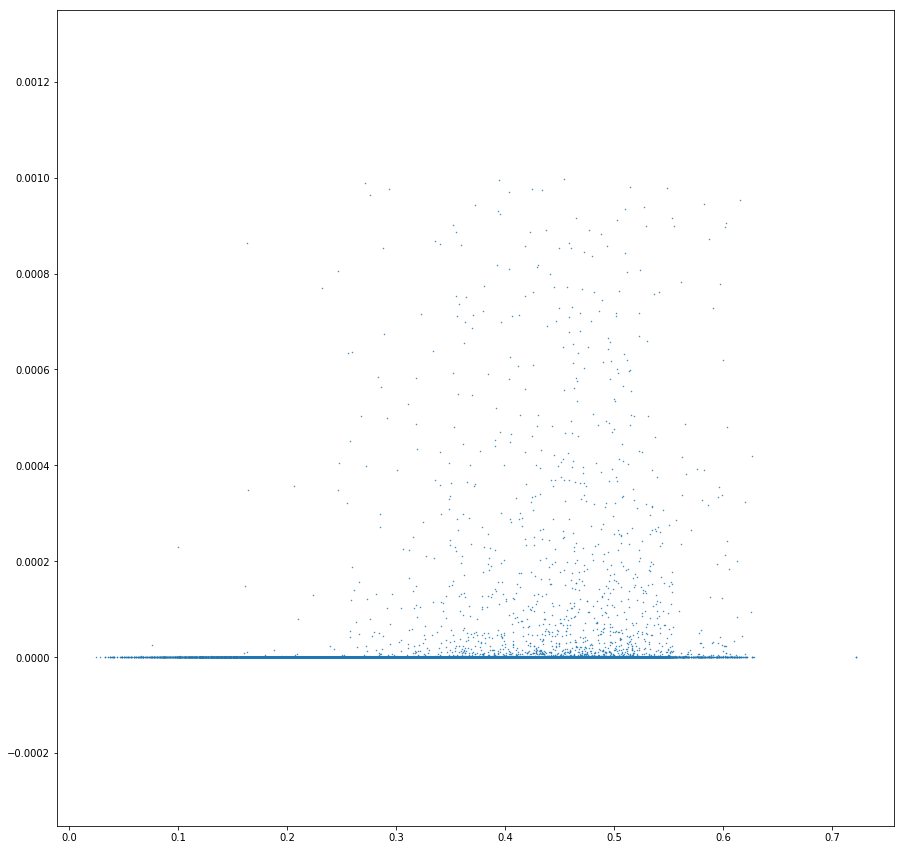

In [12]:
peaks = data.getPeaks()


# apply some cutoffs to the peaks
for peak in peaks:
    if peak.isSelected() != True:
        continue
    if peak.pValue() > 0.001:
        peak.setSelected(False)
        continue


P = []
q = []

for peak in peaks:
    if peak.isSelected() != True:
        continue
    P.append(peak.pValue())
    q.append(np.linalg.norm(peak.getQ()))
    
print(len(P), "peaks")

plt.figure(figsize=(15,15))
plt.scatter(q, P, s=0.2)
plt.show()

In [13]:
# apply some cutoffs to the peaks
num_peaks = 0
for peak in peaks:
    if peak.isSelected() != True:
        continue
        
    prof = nsx.Profile()
    if prof.fit(peak.getIntegration().getProjectionPeak()) == False:
        peak.setSelected(False)
        continue
        
    num_peaks += 1

print(num_peaks)

5566


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[   0.            0.            0.            0.           98.7171618
  520.39725018   60.64301498 -204.60274982   45.9057206     0.            0.
    0.            0.        ]
PROFILE FIT FAILED


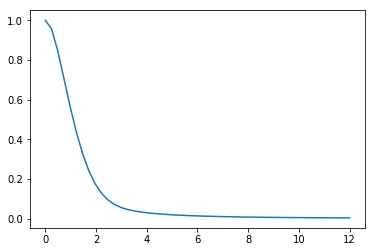

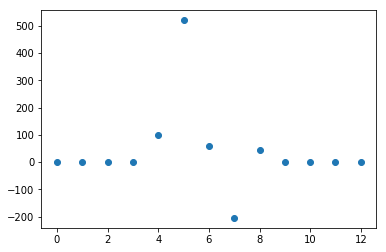

obs:   4168.482992626193
calc:  1.8751001196961203
sum:   521.060397741


In [14]:
n = 9502

peak = peaks[n]
prof = peak.getProfile()

zs = peak.getIntegration().getProjectionPeak().transpose()[0]
qs = [ z for z in zs]
xs = [x for x in range(len(qs))]

print(xs)
print(zs)

ws = np.linspace(xs[0], xs[-1:])

if not prof.fit(zs,1000):
    print("PROFILE FIT FAILED")
    
ys = [prof.evaluate(w) for w in ws ]

plt.plot(ws, ys)
plt.show()

plt.scatter(xs, qs)
plt.show()

calc = [prof.evaluate(x) for x in xs]

print("obs:  ", peak.getRawIntensity().getValue())
print("calc: ", sum(calc))
print("sum:  ", sum(qs))

In [15]:
help(nsx.PeakIntegrator)

Help on class PeakIntegrator in module pynsx:

class PeakIntegrator(builtins.object)
 |  Methods defined here:
 |  
 |  __del__ lambda self
 |  
 |  __getattr__ lambda self, name
 |  
 |  __init__(self, *args)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __repr__ = _swig_repr(self)
 |  
 |  __setattr__ lambda self, name, value
 |  
 |  __swig_destroy__ = delete_PeakIntegrator(...)
 |  
 |  end(self)
 |  
 |  getBlobShape(self, confidence)
 |  
 |  getMeanBackground(self)
 |  
 |  getPeakError(self)
 |  
 |  getPeakIntensity(self)
 |  
 |  getProjection(self)
 |  
 |  getProjectionBackground(self)
 |  
 |  getProjectionPeak(self)
 |  
 |  getRegion(self)
 |  
 |  pValue(self)
 |  
 |  step(self, frame, idx, mask)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to

In [16]:
[1,2,3,4][-1:]

[4]

In [17]:
nsx.PeakCalc(peaks[0])

<pynsx.PeakCalc; proxy of <Swig Object of type 'nsx::PeakCalc *' at 0x7f92bc2a10f0> >

In [18]:
compute_statistics(peaks, nsx.SpaceGroup("P 21 21 21"), True)

{'CChalf': 0.9795260831482396,
 'CCtrue': 0.9948151398000287,
 'Rmeas': 0.34459959693831405,
 'Rmerge': 0.2572604010531273,
 'Rpim': 0.22424312956291953}

In [22]:
high_q_peaks = []

for peak in peaks:
    if peak.isSelected() == False:
        continue
    if 1.0 / np.linalg.norm(peak.getQ()) < 2.1:
        high_q_peaks.append(peak)
        
print(len(high_q_peaks))
print(compute_statistics(peaks, nsx.SpaceGroup("P 21 21 21"), True))

972
{'CChalf': 0.9779949734545402, 'CCtrue': 0.994421985225092, 'Rmeas': 0.34459959693831405, 'Rmerge': 0.2572604010531273, 'Rpim': 0.22424312956291953}


In [27]:
for i in range(3):
    print('------------------------------------------')
    print(num_selected_peaks(data.getPeaks()))
    filter_peaks(data.getPeaks())
    remove_deselected(data)
    print(num_selected_peaks(data.getPeaks()))
    predict_peaks(data)
    print(num_selected_peaks(data.getPeaks()))
    print(compute_statistics(data.getPeaks(), nsx.SpaceGroup("P 21 21 21"), True))

------------------------------------------
57305
34163
60228
{'CChalf': 0.935247111473239, 'CCtrue': 0.9831277882040301, 'Rmeas': 1.0780909015435793, 'Rmerge': 0.8721870410195999, 'Rpim': 0.620553602383124}
------------------------------------------
60228
35403
60959
{'CChalf': 0.9292748679902176, 'CCtrue': 0.9814994042463252, 'Rmeas': 1.0811125076502994, 'Rmerge': 0.8744653228452424, 'Rpim': 0.6225103328370754}
------------------------------------------
60959
35733
61140
{'CChalf': 0.9336887485371108, 'CCtrue': 0.9827041167251658, 'Rmeas': 1.0816678518346259, 'Rmerge': 0.8748822237072296, 'Rpim': 0.6228752699972474}


In [28]:
good_peaks = data.getPeaks()
filter_peaks(good_peaks)
compute_statistics(good_peaks, nsx.SpaceGroup("P 21 21 21"), True)

{'CChalf': 0.9324459267342173,
 'CCtrue': 0.9823656102556102,
 'Rmeas': 0.7382091065666312,
 'Rmerge': 0.5986943522200365,
 'Rpim': 0.42340954626545074}

In [31]:
merged = nsx.MergedData(nsx.SpaceGroup("P 21 21 21"), True)

for peak in good_peaks:
    if peak.isSelected():
        merged.addPeak(nsx.PeakCalc(peak))
        
p = []
q = []
        
for peak in merged.getPeaks():
    p.append(peak.pValue())
    q.append(numpy.linalg.norm(peak.getPeaks()[0].getQ()))

TypeError: 'SwigPyObject' object is not iterable